# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Loads first-time contributor data frame.
ftc_df = df[df[ftc_key]]
print(f'{len(df)=}')
print(f'{len(ftc_df)=}')

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field not in dependent_fields)]

df[independent_fields].describe()


Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullReq

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),...,ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,...,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06
mean,5.032730e-01,4.034645e-01,9.889740e-02,5.955645e-02,4.193296e-01,1.184218e-01,2.985197e-01,1.691039e-01,1.420826e-01,5.359085e-02,...,1.639801e-02,3.941424e-02,8.724590e-02,1.451003e-01,1.151620e-02,1.976215e-02,9.566235e-03,1.757943e-02,8.884955e-02,7.438409e-02
std,4.710991e-01,4.525011e-01,2.911891e-01,2.291140e-01,2.257136e-01,7.155493e-02,1.868852e-01,1.844545e-01,1.853726e-01,1.297009e-01,...,7.423245e-02,1.070026e-01,1.245128e-01,1.815019e-01,5.415120e-02,8.022241e-02,5.261483e-02,8.245254e-02,1.050997e-01,9.868875e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.363720e-01,7.525668e-02,1.658047e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.875000e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.430126e-01,7.525668e-02,2.972018e-01,9.318519e-02,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.426778e-02,3.550956e-02
75%,1.000000e+00,9.399033e-01,0.000000e+00,0.000000e+00,5.858949e-01,1.505134e-01,4.381723e-01,3.095545e-01,2.734346e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.575606e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366330e-01,1.119194e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Log-odds linearity


### Visual checking


untransformed
IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.500000
0.25    0.863636
0.40    0.954545
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.75, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.08879700603413891, 1.6197842044882447, 2.5632269785604915, 2.560332930978825, 2.4967194248068423, 2.4967194248068423, 2.4967194248068423, 2.4967194248068423]
EcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.333333
0.25    0.750000
0.40    0.885714
0.50    0.937500
0.60    0.993750
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: EcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.6099095939521472, 0.8243243243243243, 0.9142857142857144, 0.96, 1.0, 1.0, 1.0], y=[0.7907051887059179, 1.2398137842822332, 1.7748074338764224, 2.1962773621671463, 2.6412864617637464, 1.8051726606238963, 1.802

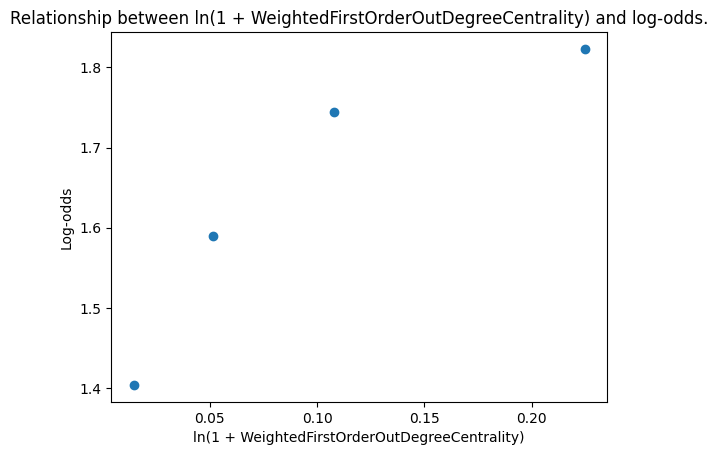

In [2]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame,
    dependent: pd.Series,
    transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include='number')

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r'.*SuccessRate.*', field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[:-len('SuccessRate')]
            count_field = f'ln(1 + {stripped_field}SubmissionCount)'
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f'{field}:')
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[(
                included[field] >= r_start) & (included[field] <= r_end)]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f'Skipped {field} because of division by zero.')
            continue

        print(f'{x=}, {y=}')

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = f'{figure_base_path}/log-odds-independence/{transform_title}/{field}'
        safe_save_fig(output_path)


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include='number')
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field]\
                .apply(transform)
            mn = transformed_independents[field].min()
            mx = transformed_independents[field].max()
            transformed_independents[field] = transformed_independents[field]\
                .apply(lambda x: (x - mn) / (mx - mn))
        test_log_linearity(transformed_independents,
                           dependent, f'{figure_subfolder}/{transform.__name__}')


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value ** 2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value ** 3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, "full_model")


## Box-Tidwill Test

In [3]:
import statsmodels.api as sm


def box_tidwill_test(
    independents: pd.DataFrame(),
    dependent: pd.Series()
):
    continuous_fields = independents.select_dtypes(include='number')

    ln_field = f'ln(x) * x'
    for field in continuous_fields:
        test_independents = independents[[field]].copy()
        # TODO: Can you do this?! the ``1 + x`` thing?
        test_independents[ln_field] = test_independents[field]\
            .apply(lambda x: np.log(0.0001 + x) * (0.0001 + + x))
        test_independents = sm.add_constant(test_independents)

        logit_model = sm.Logit(dependent,
                               test_independents).fit()

        p_value = logit_model.pvalues[ln_field]
        is_significant = p_value < 0.05

        test_result = "failed" if is_significant else "passed"
        print(f'{field} {test_result} with {p_value=:.05f}.')


independents: pd.DataFrame = df[independent_fields]
dependent: pd.Series = df[pr_merged_key]
box_tidwill_test(independents, dependent)


Optimization terminated successfully.
         Current function value: 0.457682
         Iterations 7
IntraProjectSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.502466
         Iterations 6
EcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.509655
         Iterations 6
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.512735
         Iterations 7
InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.459162
         Iterations 6
ln(1 + ControlPullRequestLifeTimeInMinutes) failed with p_value=0.00000.
Optimization terminated successfully.
         Current function value: 0.514

## Multicolinearity


In [4]:

multicollinear_fields = [
    # Ignored field.
    "SubmitterIsFirstTimeContributor",


    # ### Cluter: Regular dependency ecosystem.
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    # "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",


    # ### Cluster: Inversed dependency ecosystem.
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    # "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",


    # ### Cluster: Shared experience.
    # "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)",
    "ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator)",
    "ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter)",
    "ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter)",
    # ### Cluster-tails:
    # "ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)",
    # "ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)",
    # ### Cluster-tail/Bridge:
    # "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)",
    "ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)",


    # ### Cluster: Intra-project experience
    "IntraProjectSubmitterPullRequestSuccessRate",
    # "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
    # ### Cluster bridge (between intra-project and ecosystem experience.)
    # "ln(1 + WeightedFirstOrderInDegreeCentrality)",
    "ln(1 + WeightedFirstOrderOutDegreeCentrality)",
    # ### Cluster 2: Ecosystem experience.
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    # "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)"
]

print(f'Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity.')


Removing 22 / 38 fields to account for multicollinearity.


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(tested_predictors)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


                                             variable       VIF
0                         ControlIntegratedBySameUser  2.599151
1                       ControlPullRequestHasComments  3.561070
2                      ControlHasHashTagInDescription  1.569283
3          ControlPullRequestHasCommentByExternalUser  1.727071
4         ln(1 + ControlPullRequestLifeTimeInMinutes)  4.183521
5         ln(1 + ControlNumberOfCommitsInPullRequest)  3.610524
6   ln(1 + ControlIntraProjectPullRequestExperienc...  3.741432
7   ln(1 + SharedExperiencePullRequestSubmittedByS...  2.118038
8   ln(1 + SharedExperiencePullRequestSubmittedByI...  1.662544
9   ln(1 + EcosystemExperienceSubmitterPullRequest...  2.591382
10  ln(1 + DependencyEcosystemExperienceSubmitterP...  1.560546
11  ln(1 + InversedDependencyEcosystemExperienceSu...  1.377965
12  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.906662
13  ln(1 + SharedExperienceIssueSubmittedBySubmitt...  1.782426
14  ln(1 + SharedExperienceIssueSubmitte

In [6]:
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


Problematic VIF fields: 0.
Problematic VIF scores:
Empty DataFrame
Columns: [variable, VIF]
Index: []


coof_threshold=0.5
Correlating pairs:
[]

Variable correlation frequency:
[]

Transitive closure of correlating pairs:
[
    []
]


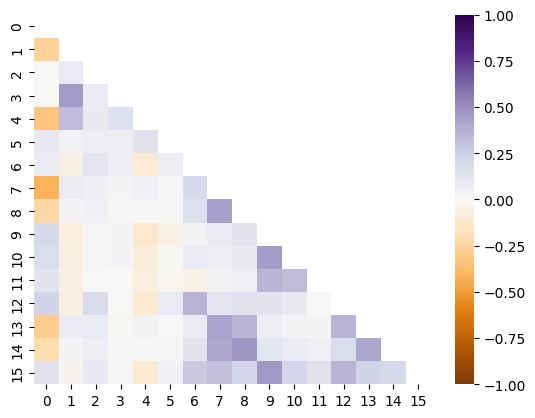

In [7]:
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = tested_predictors.corr(method='spearman')

rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))


Plots a graph when there are correlating fields.


In [8]:
import networkx as nx
import matplotlib.pyplot as plt

if len(correlating_fields) > 0:
    fields = list(tested_predictors.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append('red' if coof < 0 else 'green')

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

    output_path = f'{figure_base_path}/correlating_fields.png'
    safe_save_fig(output_path)

    print(json.dumps(enumerated_list))


In [9]:
print(f'{len(tested_predictors.columns)=}')
print(f'{tested_predictors.columns=}')


len(tested_predictors.columns)=16
tested_predictors.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlHasHashTagInDescription',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)',
       'ln(1 + SharedExperien

## Outliers

Using cook's distance.


In [10]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(tested_predictors)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(df[pr_merged_key], X_constant,
                       family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(tested_predictors)

# Append absolute standardized residual values
diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(
    lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) &
                       (diagnosis_df['std_resid'] > 3)]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)


/tmp/ipykernel_988/2490181039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_988/2490181039.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(


,cooks_d,std_resid
293355,0.000131,4.112507
853099,0.000127,4.242675
899536,0.000115,5.352759
559573,0.000111,5.560672
739159,0.000109,5.963165
739004,0.000109,6.100889
738900,0.000106,4.660769
899630,0.000105,3.188052
478012,0.000105,11.782829
899867,0.000104,7.990899


3.266370025828821e-06
Found outliers: 21301 / 1224618 (1.739%)


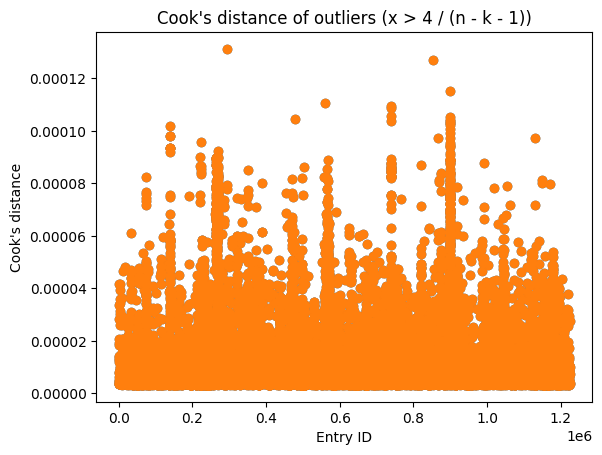

In [11]:
cook_threshold = 4 / (len(tested_predictors) -
                      len(tested_predictors.columns) - 1)
print(cook_threshold)
print(
    f'Found outliers: {len(extreme)} / {len(tested_predictors)} ({100 * len(extreme)/len(tested_predictors):.03f}%)')

plt.scatter(extreme.index, extreme['cooks_d'])

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme['cooks_d'])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f'{figure_base_path}/cooks_outliers.png'
safe_save_fig(output_path)


Removes outliers

In [12]:
tested_predictors = tested_predictors.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)


# Model Creation

Creates a simple mixed effect logistic regression model.

In [13]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[tested_predictors.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    tested_predictors,
    tested_projects,
).fit()

mixed_model.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     1203317                     Method:                                 REML               
No. Groups:                           20051                       Scale:                                  0.0977             
Min. group size:                      1                           Log-Likelihood:                         -361234.7506       
Max. group size:                      694                         Converged:                              Yes                
Mean group size:                      60.0                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                                      -0.222    0.001 -258.722 0.000 -0.223 -0.220
ControlPullRequestHasComments                                                    -0.122    0.001 -156.294 0.000 -0.124 -0.121
ControlHasHashTagInDescription                                                    0.032    0.001   47.380 0.000  0.031  0.033
ControlPullRequestHasCommentByExternalUser                                        0.033    0.001   36.919 0.000  0.031  0.034
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.409    0.002 -256.779 0.000 -0.412 -0.406
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.243    0.004   54.440 0.000  0.234  0.252
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)                      1.259    0.003  411.395 0.000  1.253  1.265
ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)    -0.077    0.003  -23.671 0.000 -0.083 -0.071
ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter)   -0.199    0.006  -35.069 0.000 -0.210 -0.188
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)                    0.261    0.002  113.551 0.000  0.257  0.266
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)         -0.006    0.005   -1.372 0.170 -0.015  0.003
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount) -0.031    0.006   -5.514 0.000 -0.042 -0.020
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                 0.069    0.003   20.410 0.000  0.062  0.075
ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator)         -0.111    0.004  -25.447 0.000 -0.120 -0.102
ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter)         -0.008    0.005   -1.598 0.110 -0.019  0.002
ln(1 + WeightedFirstOrderInDegreeCentrality)                                      0.090    0.003   26.453 0.000  0.083  0.096
Group Var                                                                         0.808    0.027                             
=============================================================================================================================

"""